In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import matplotlib.pyplot as plt

from monte_carlo import wolff_algorithm
from xy_model import XYModel2DWolff
from logger import Logger
import pickle

def show_spin(xy_model: XYModel2DWolff):
    x, y = np.meshgrid(np.arange(xy_model.grid_size), np.arange(xy_model.grid_size))
    spin = xy_model.get_spin()

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(3, 3)
    ax.quiver(x, y, spin.cos(), spin.sin())
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_yticks([])

    return fig, ax

def set_seed(seed):
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

get_M = lambda spin: (spin.cos().sum().square() + spin.sin().sum().square()).sqrt() / spin.size(0) ** 2


In [96]:
# run and save

def run_exp(L, step_num, T):
    xy_model = XYModel2DWolff(L, )
    logger = wolff_algorithm(xy_model, T, step_num)
    pickle.dump(logger, open(f'./save/xy_model_L={L}_T={T}_step_num={step_num}.pkl', 'wb'))
    return logger


set_seed(0)
step_num = 1000
L = 10
Ts = np.linspace(0.1, 1, 100)
for i, T in enumerate(Ts):
    print(f'{i} runs out of {Ts.shape[0]}')
    run_exp(L, step_num, T)

0 runs out of 100


100%|██████████| 1000/1000 [00:28<00:00, 35.05it/s]


1 runs out of 100


100%|██████████| 1000/1000 [00:29<00:00, 34.33it/s]


2 runs out of 100


100%|██████████| 1000/1000 [00:30<00:00, 32.90it/s]


3 runs out of 100


100%|██████████| 1000/1000 [00:31<00:00, 31.67it/s]


4 runs out of 100


100%|██████████| 1000/1000 [00:29<00:00, 33.82it/s]


5 runs out of 100


100%|██████████| 1000/1000 [00:30<00:00, 32.50it/s]


6 runs out of 100


100%|██████████| 1000/1000 [00:33<00:00, 29.71it/s]


7 runs out of 100


100%|██████████| 1000/1000 [00:33<00:00, 29.91it/s]


8 runs out of 100


100%|██████████| 1000/1000 [00:34<00:00, 29.31it/s]


9 runs out of 100


100%|██████████| 1000/1000 [00:36<00:00, 27.58it/s]


10 runs out of 100


100%|██████████| 1000/1000 [00:34<00:00, 29.21it/s]


11 runs out of 100


100%|██████████| 1000/1000 [00:35<00:00, 28.30it/s]


12 runs out of 100


100%|██████████| 1000/1000 [00:37<00:00, 26.74it/s]


13 runs out of 100


100%|██████████| 1000/1000 [00:37<00:00, 26.53it/s]


14 runs out of 100


100%|██████████| 1000/1000 [00:38<00:00, 25.86it/s]


15 runs out of 100


100%|██████████| 1000/1000 [00:37<00:00, 26.51it/s]


16 runs out of 100


100%|██████████| 1000/1000 [00:41<00:00, 24.06it/s]


17 runs out of 100


100%|██████████| 1000/1000 [00:41<00:00, 23.95it/s]


18 runs out of 100


100%|██████████| 1000/1000 [00:42<00:00, 23.41it/s]


19 runs out of 100


100%|██████████| 1000/1000 [00:41<00:00, 23.85it/s]


20 runs out of 100


100%|██████████| 1000/1000 [10:40<00:00,  1.56it/s] 


21 runs out of 100


100%|██████████| 1000/1000 [00:43<00:00, 22.88it/s]


22 runs out of 100


100%|██████████| 1000/1000 [00:44<00:00, 22.64it/s]


23 runs out of 100


100%|██████████| 1000/1000 [00:44<00:00, 22.60it/s]


24 runs out of 100


100%|██████████| 1000/1000 [00:46<00:00, 21.63it/s]


25 runs out of 100


100%|██████████| 1000/1000 [00:47<00:00, 21.26it/s]


26 runs out of 100


100%|██████████| 1000/1000 [00:47<00:00, 21.24it/s]


27 runs out of 100


100%|██████████| 1000/1000 [00:47<00:00, 20.98it/s]


28 runs out of 100


100%|██████████| 1000/1000 [00:49<00:00, 20.06it/s]


29 runs out of 100


100%|██████████| 1000/1000 [00:49<00:00, 20.36it/s]


30 runs out of 100


100%|██████████| 1000/1000 [00:50<00:00, 19.90it/s]


31 runs out of 100


100%|██████████| 1000/1000 [00:50<00:00, 19.66it/s]


32 runs out of 100


100%|██████████| 1000/1000 [00:51<00:00, 19.31it/s]


33 runs out of 100


100%|██████████| 1000/1000 [00:52<00:00, 19.14it/s]


34 runs out of 100


100%|██████████| 1000/1000 [00:54<00:00, 18.19it/s]


35 runs out of 100


100%|██████████| 1000/1000 [00:54<00:00, 18.35it/s]


36 runs out of 100


100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]


37 runs out of 100


100%|██████████| 1000/1000 [00:57<00:00, 17.26it/s]


38 runs out of 100


100%|██████████| 1000/1000 [00:59<00:00, 16.75it/s]


39 runs out of 100


100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]


40 runs out of 100


100%|██████████| 1000/1000 [01:01<00:00, 16.38it/s]


41 runs out of 100


100%|██████████| 1000/1000 [01:01<00:00, 16.38it/s]


42 runs out of 100


100%|██████████| 1000/1000 [01:02<00:00, 15.97it/s]


43 runs out of 100


100%|██████████| 1000/1000 [01:00<00:00, 16.49it/s]


44 runs out of 100


100%|██████████| 1000/1000 [01:00<00:00, 16.50it/s]


45 runs out of 100


100%|██████████| 1000/1000 [01:02<00:00, 15.94it/s]


46 runs out of 100


100%|██████████| 1000/1000 [01:02<00:00, 16.07it/s]


47 runs out of 100


100%|██████████| 1000/1000 [01:00<00:00, 16.41it/s]


48 runs out of 100


100%|██████████| 1000/1000 [01:00<00:00, 16.51it/s]


49 runs out of 100


100%|██████████| 1000/1000 [01:00<00:00, 16.61it/s]


50 runs out of 100


100%|██████████| 1000/1000 [00:59<00:00, 16.73it/s]


51 runs out of 100


100%|██████████| 1000/1000 [00:59<00:00, 16.83it/s]


52 runs out of 100


 29%|██▉       | 294/1000 [00:17<00:50, 13.87it/s]

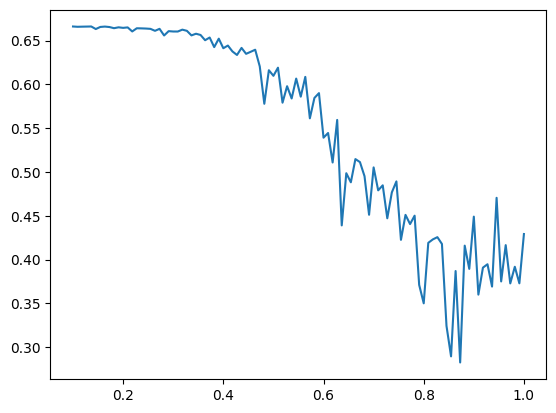

In [94]:
def binder_cumulant(spins):
    idx = np.arange(200, 1000, 7)
    spins = spins[idx]
    m = (spins.sin().mean((-1, -2)) ** 2 + spins.cos().mean((-1, -2)) ** 2).sqrt()
    binder = 2 - (m ** 4).mean() / (2 * (m ** 2).mean() ** 2)
    return binder

def load_logger(L, step_num, T):
    logger = pickle.load(open(f'./save/xy_model_L={L}_T={T}_step_num={step_num}.pkl', 'rb'))
    return logger

step_num = 1000
L = 5
Ts = np.linspace(0.1, 1, 100)
b = []
for i, T in enumerate(Ts):
    logger = load_logger(L, step_num, T)
    b.append(binder_cumulant(logger.states[:, 0, ...]))

fig, ax = plt.subplots(1, 1)
ax.plot(Ts, b)

100%|██████████| 20/20 [00:00<00:00, 2367.46it/s]


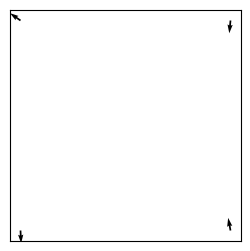

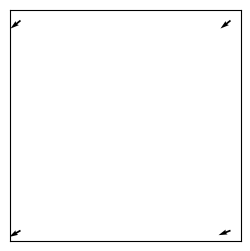

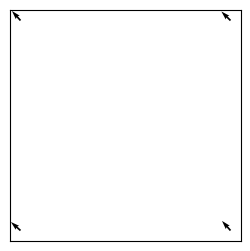

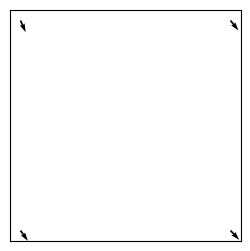

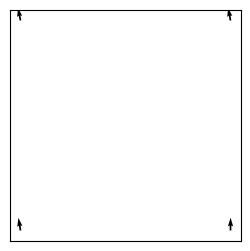

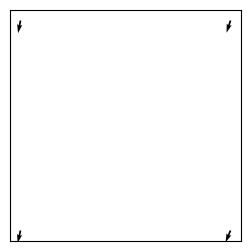

In [80]:
seed = 1
grid_size = 2
temp = 0.1

set_seed(seed)
xy_model = XYModel2DWolff(grid_size)
show_spin(xy_model)

for _ in range(5):
    logger = wolff_algorithm(xy_model, temp, 20)
    show_spin(xy_model)


In [49]:
# try to determine phase change
sim_steps = 100

def sim(temp, grid_size) -> Logger:
    xy_model = XYModel2DWolff(grid_size, )
    logger = wolff_algorithm(xy_model, temp, sim_steps, stamp_interval=1)    
    return logger


def phase_change_exp(temps, grid_sizes):
    loggers_L = []
    for grid_size in grid_sizes:
        loggers_L.append([])
        for temp in temps:
            logger = sim(temp, grid_size)
            loggers_L[-1].append(logger)        
    return loggers_L

temps = np.linspace(0.1, 0.8, 10)
grid_sizes = [10, 20, 30]
loggers_L = phase_change_exp(temps, grid_sizes=grid_sizes)


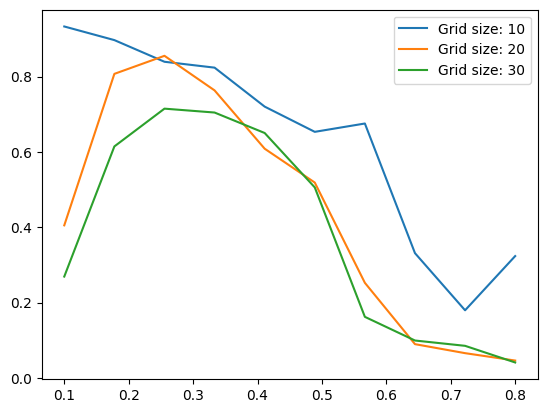

In [50]:
x: Logger = 1

fig, ax = plt.subplots(1, 1)
for loggers, grid_size in zip(loggers_L, grid_sizes):
    
    get_M_from_logger = lambda logger: np.mean([get_M(logger.get_log(i)[0]) for i in range(-10, -1)])
    ax.plot(temps, [get_M_from_logger(logger) for logger in loggers], label=f'Grid size: {grid_size}')

ax.legend()

(<Figure size 300x300 with 1 Axes>, <Axes: >)

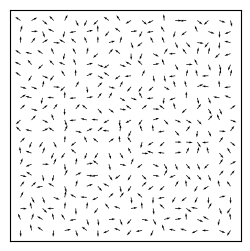

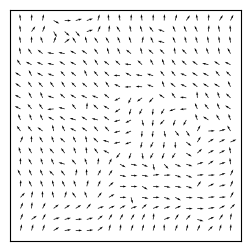

In [52]:

set_seed(seed)
temp = 0.1
grid_size = 20

xy_model = XYModel2DWolff(grid_size)
fig, ax = show_spin(xy_model)

Ms = []
for _ in range(100):
    Ms.append(get_M(xy_model.get_spin()))

    # randomly choose a Wolff plane        
    nW = 2 * torch.pi * torch.rand((1, )).item()
    
    # update bond according to the Wolff plane
    xy_model.update_bond(nW=nW, beta=1 / temp)

    # select one cluster according to the bond
    # flip_cluster = xy_model.flip_one_cluster(nW=nW, debug=True)
    xy_model.flip_all_clusters(nW=nW)
    
    # print(f'M {get_M(xy_model)}')

    # ax.imshow(flip_cluster)
    # print(flip_cluster * (xy_model.get_spin() - nW).cos() <= 0)

show_spin(xy_model)